# IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# IMPORTING DATASET 

In [3]:
stock = pd.read_csv("meb.csv")

In [4]:
stock.head(2)

,Date,Open,High,Low,Close,Volume
0,2018-01-01,67.0,67.69,67.0,67.20,1051500
1,2018-01-02,67.0,70.56,67.0,70.56,51500


## extracting out dates for later use[visualization and forecast purpose]

In [5]:
import datetime as dt

In [6]:
dates = list(stock['Date'])
dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [7]:
print("Starting date of record : " , dates[0])
print("Last date of record : " , dates[-1])
print("Total days n(records) = ",len(dates))

Starting date of record :  2018-01-01
Last date of record :  2022-05-18
Total days n(records) =  1071


## creating dataset of chosen features to work ahead with LSTM-model

In [8]:
features = list(stock)[1:]

In [9]:
data = stock[features]

In [10]:
data.head(2)

,Open,High,Low,Close,Volume
0,67.0,67.69,67.0,67.20,1051500
1,67.0,70.56,67.0,70.56,51500


In [11]:
print("The features selected to train the model are : ", data.columns.values)

The features selected to train the model are :  ['Open' 'High' 'Low' 'Close' 'Volume']


# DATA PRE-PROCESSING 

In [12]:
data = data.astype(float)

In [13]:
data.head(2)

,Open,High,Low,Close,Volume
0,67.0,67.69,67.0,67.20,1051500.0
1,67.0,70.56,67.0,70.56,51500.0


In [14]:
dataset = data.values

In [15]:
dataset.shape

(1071, 5)

In [16]:
dataset[0]

array([6.7000e+01, 6.7690e+01, 6.7000e+01, 6.7200e+01, 1.0515e+06])

In [17]:
dataset[:,-1:]

array([[1051500.],
       [  51500.],
       [  23000.],
       ...,
       [ 515648.],
       [ 291169.],
       [ 383890.]])

# FEATURE SCALING

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc_dataset = sc.fit_transform(dataset)

pred_sc = StandardScaler()
pred_sc.fit_transform(dataset[:, -1: ]) #for output values

array([[ 0.26235078],
       [-0.70274236],
       [-0.73024752],
       ...,
       [-0.25479631],
       [-0.47143945],
       [-0.38195505]])

# INPUT-OUTPUT SPLIT FOR TIME SERIES ANALYSIS 

In [19]:
Xtrain = [] #trend to be analyzed
ytrain = [] #output for the given-trend

In [20]:
nFuture = 1 #60 #7 #30   # Number of days we want top predict into the future
nPast = 30 #90 #30 #100     # Number of past days we want to use to predict the future 

In [21]:
rows = data.shape[0]
cols = data.shape[1]

In [22]:
rows, cols

(1071, 5)

In [23]:
rows = dataset.shape[0]
cols = dataset.shape[1]
for i in range(nPast ,  rows - nFuture +1):
    Xtrain.append(sc_dataset[i - nPast : i , 0:cols])
    ytrain.append(sc_dataset[i + nFuture - 1 : i + nFuture , -1])

In [24]:
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

In [25]:
sc.inverse_transform([Xtrain[0][0]])

array([[6.7000e+01, 6.7690e+01, 6.7000e+01, 6.7200e+01, 1.0515e+06]])

In [26]:
pred_sc.inverse_transform([ytrain[0]])

array([[53000.]])

In [27]:
Xtrain[nFuture + nPast - 1][0]

array([-1.00262077, -0.99014544, -0.95805047, -0.96057   , -0.70129472])

In [28]:
ytrain[0]

array([-0.70129472])

Now the Xtrain contains all of the given dataset , where as ytrain contains value of volumes to be predicted at gievn past and future figures

In [29]:
sc.inverse_transform([Xtrain[nFuture + nPast - 1][0]])[0][-1]

53000.0

In [30]:
pred_sc.inverse_transform([ytrain[0]])[0][0]

53000.0

# MODEL TRAINING 

## IMPORTING LIBRARIES

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras import optimizers

2022-05-27 00:57:53.702055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 00:57:53.702089: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Training Model

In [32]:
from tensorflow import keras

In [33]:
model = Sequential()

#LAYERS
model.add(LSTM(units=128, return_sequences=True, input_shape=(Xtrain.shape[1] , Xtrain.shape[2]))) #first layer #nPast , cols
model.add(LSTM(units=64 , activation = "linear", return_sequences=True , kernel_regularizer=keras.regularizers.l2(0.01) )) #second layer
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation = "tanh", return_sequences=True , kernel_regularizer=keras.regularizers.l2(0.01) )) #second layer
model.add(Dropout(0.2))
model.add(LSTM(units=10,return_sequences=False )) #third layers

#DROPOUT
model.add(Dropout(0.5))

#OUTPUT
model.add(Dense(ytrain.shape[1])) #output layer
# model.summary()

2022-05-27 00:57:59.249260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 00:57:59.249320: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 00:57:59.249361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (huda): /proc/driver/nvidia/version does not exist
2022-05-27 00:57:59.249724: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compling NN 

In [34]:
from tensorflow.keras import losses

In [35]:
opmz = optimizers.Adam(learning_rate=0.01)
loss = losses.mean_squared_error

model.compile(optimizer = opmz , loss = loss)

In [36]:
#linear , tanh , 0.05 , 25, 128

## Fitting dataset to model 

In [37]:
history = model.fit(Xtrain, ytrain, epochs=25, batch_size=256, validation_split=0.1, verbose=1) #100e #32b

Epoch 1/25
4/4 [==============================] - 8s 668ms/step - loss: 3.2942 - val_loss: 2.2578
Epoch 2/25
4/4 [==============================] - 1s 195ms/step - loss: 2.0947 - val_loss: 1.6216
Epoch 3/25
4/4 [==============================] - 1s 194ms/step - loss: 1.5529 - val_loss: 1.4023
Epoch 4/25
4/4 [==============================] - 1s 196ms/step - loss: 1.3486 - val_loss: 1.2387
Epoch 5/25
4/4 [==============================] - 1s 191ms/step - loss: 1.2346 - val_loss: 1.2194
Epoch 6/25
4/4 [==============================] - 1s 194ms/step - loss: 1.1772 - val_loss: 1.1718
Epoch 7/25
4/4 [==============================] - 1s 194ms/step - loss: 1.1215 - val_loss: 1.0946
Epoch 8/25
4/4 [==============================] - 1s 194ms/step - loss: 1.0748 - val_loss: 1.0269
Epoch 9/25
4/4 [==============================] - 1s 196ms/step - loss: 1.0255 - val_loss: 1.0406
Epoch 10/25
4/4 [==============================] - 1s 191ms/step - loss: 1.0016 - val_loss: 1.0753
Epoch 11/25
4/4 [==

# loss plot

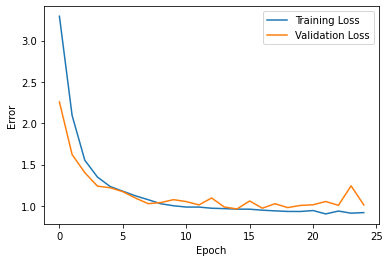

In [38]:
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(train_loss , label = "Training Loss")
plt.plot(validation_loss , label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

# FUTURE FORECAST: 

In [39]:
nFut = 30

In [40]:
futureDates = pd.date_range(dates[-1], periods=nFut, freq='1d').tolist()

In [41]:
futureDatesList = []
for i in futureDates:
    futureDatesList.append(i.date())

In [42]:
futureDatesList[0]

datetime.date(2022, 5, 18)

In [43]:
futureDatesList[-1]

datetime.date(2022, 6, 16)

In [44]:
futurePreds = model.predict(Xtrain[-nFut:])
trainPreds = model.predict(Xtrain[nPast:])

In [45]:
def to_Timestamp(x):
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [46]:
y_predFuture = pred_sc.inverse_transform(futurePreds)
y_predTrain = pred_sc.inverse_transform(trainPreds)

In [47]:
FUT_PREDS = pd.DataFrame(y_predFuture, columns=["Volume"]).set_index(pd.Series(futureDatesList))
TRAIN_PREDS = pd.DataFrame(y_predTrain, columns=["Volume"]).set_index(pd.Series(dates[2 * nPast + nFuture - 1:]))

In [48]:
TRAIN_PREDS.index = TRAIN_PREDS.index.to_series().apply(to_Timestamp)

In [49]:
TRAIN_PREDS.head(2)

,Volume
2018-04-05,392784.6250
2018-04-06,382619.8125


In [50]:
trainSet = pd.DataFrame(data, columns=features)
trainSet.index = dates
trainSet.index = pd.to_datetime(trainSet.index)

In [51]:
trainSet.head(2)

,Open,High,Low,Close,Volume
2018-01-01,67.0,67.69,67.0,67.20,1051500.0
2018-01-02,67.0,70.56,67.0,70.56,51500.0


In [52]:
TRAIN_PREDS.index[0]

Timestamp('2018-04-05 00:00:00')

In [53]:
from pylab import rcParams

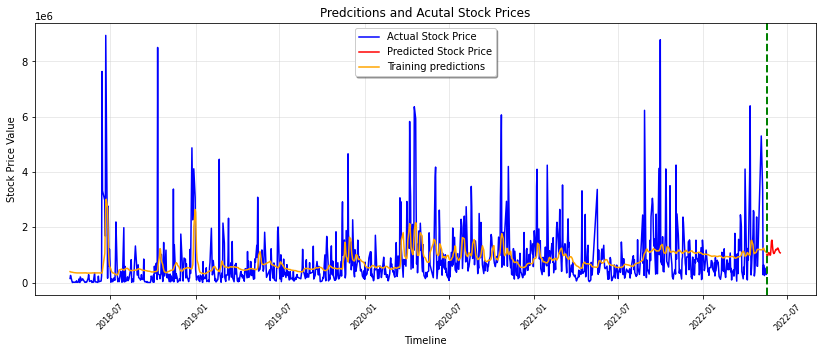

In [54]:
rcParams['figure.figsize'] = 14, 5

# Plotting
STARTDATE = TRAIN_PREDS.index[0]

plt.plot(trainSet.loc[STARTDATE:].index, trainSet.loc[STARTDATE:]["Volume"], color='blue', label='Actual Stock Price')
plt.plot(FUT_PREDS.index, FUT_PREDS["Volume"], color='red', label='Predicted Stock Price')
plt.plot(TRAIN_PREDS.loc[STARTDATE:].index, TRAIN_PREDS.loc[STARTDATE:]["Volume"], color='orange', label='Training predictions')

plt.axvline(x = min(FUT_PREDS.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Stock Price Value', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

<AxesSubplot:>

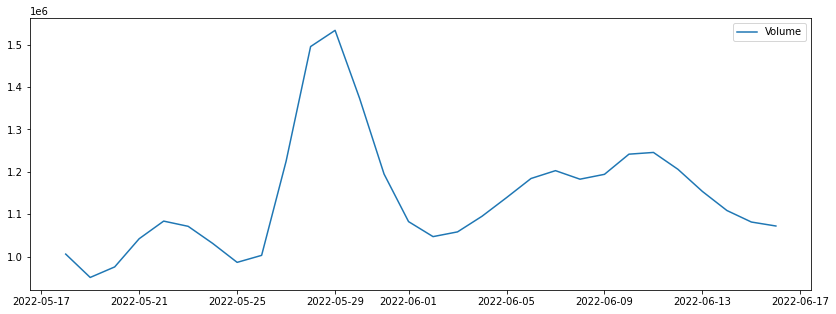

In [55]:
FUT_PREDS.plot()

In [56]:
m = keras.models.load_model("model1.h5")

In [57]:
futurePreds = m.predict(Xtrain[-nFut:])

In [58]:
fp = pred_sc.inverse_transform(futurePreds)

In [62]:
FS = pd.DataFrame(y_predFuture, columns=["Volume"]).set_index(pd.Series(futureDatesList))

<AxesSubplot:>

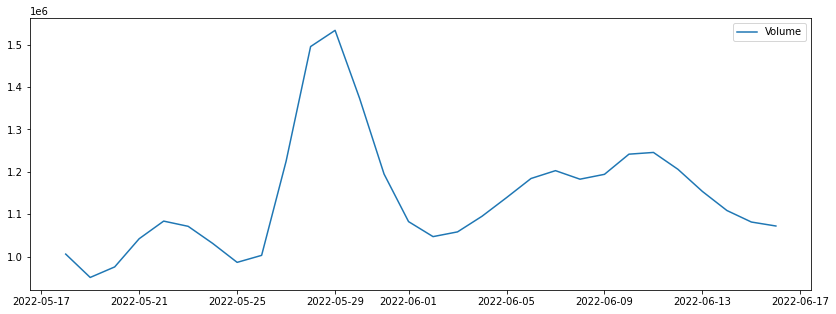

In [63]:
FS.plot()